#### Pakkar

In [0]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GRU, LSTM
import tensorflow as tf
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

In [0]:
tf.compat.v1.disable_eager_execution()
import warnings; 
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

#### Innlestur gagna

In [0]:
train_data = pd.read_csv('data/train.csv',delimiter=',')

test_data = pd.read_csv('data/test.csv',delimiter=',')


### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [4]:
display(train_data.head())
cols = train_data.columns
print('Dálkarnir eru: ')
for col in cols:
    print('- \t',col)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Dálkarnir eru: 
- 	 id
- 	 comment_text
- 	 toxic
- 	 severe_toxic
- 	 obscene
- 	 threat
- 	 insult
- 	 identity_hate


In [5]:
display(test_data.head())

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Text preprocessing


Hér er þá búið að preprocessa textann

In [0]:
max_comment_length = len(train_data['comment_text'][0])

for comment in train_data['comment_text']:
    if len(comment) > max_comment_length:
        max_comment_length = len(comment)

Prófa að exclude-a bara toxic dálkinn og gera model á honum

In [0]:
# toxicCol = train_data['toxic']
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [14]:
# X_train = train_data['comment_text'].to_numpy()
X_train = temp
# y_train = (train_data.values[:,2:])
y_train = train_data[classes]
print(len(y_train), len(X_train))
# Set aside validation data for monitoring training progress

assert len(X_train) == len(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

159571 159571
| train_data shape: (127656,)
| 127656 train samples
| 31915 test samples


### 92% acc. model

In [0]:
inp = Input(shape=(max_comment_length,))
model = Sequential()
model = Embedding(max_words, output_vector_len)(inp) 
#Embedded útskýring:
    #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
model = Dropout(0.5)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Dropout(0.5)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Dropout(0.5)(model)
model = GRU(128)(model)

model = Dense(64, activation="relu")(model)
model = Dense(32, activation="relu")(model)
model = Dense(16, activation="relu")(model)
model = Dense(6, activation="sigmoid")(model)
model = Model(inputs=inp, outputs=model)
model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=[tf.keras.metrics.AUC()])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
model.summary()

In [0]:
batch_size = 32
epochs = 1
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))

In [0]:
predictions = model.predict(x_test,batch_size=32, verbose=0)

In [0]:
print(predictions)

In [0]:
assert predictions.shape == y_test.shape
print(predictions.shape)
print(y_test.shape)

In [0]:

for line in range(predictions.shape[0]):
    for item in range(predictions.shape[1]):
        if predictions[line,item] > 0.5:
            predictions[line,item] = 1
        else:
            predictions[line,item] = 0
        

In [0]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

totals_mat = confusion_matrix(y_test.astype(int).ravel(), predictions.astype(int).ravel())
plot_conf_mat(totals_mat)

### Ýmsar aðferðir

In [0]:
def Oversample(classes,train_data):
    for className in classes:
        count_class_0, count_class_1=train_data[className].value_counts()
        df_class_1 = train_data[train_data[className] == 1]
        df_class_0 = train_data[train_data[className] == 0]
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
        #print(df_test_over[className].value_counts())
    return df_test_over

In [0]:
def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.seismic,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
    plt.grid(None)
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()

In [0]:
from numpy.random import default_rng
def getrandomSubset(x,y,size):
  rng = default_rng()
  numbers = rng.choice(len(x), size=size, replace=False)
  return x[numbers], y[numbers]

In [41]:
import seaborn as sn
def plot_conf_mat(mat, cmap_="OrRd" ):
    tn, fp, fn, tp  = mat.ravel()
    print('-'*50)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The specificity is: {:.2%}".format(tn/(tn+fp)))
    print("The precision is: {:.2%}".format(tp/(tp+fp)))
    print('-'*50)
    ax = sn.heatmap(mat, annot=True, fmt="d", cmap=cmap_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Lætur tölurnar vera í miðjum kassanum
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stopWords = set(stopwords.words('english'))
def removeStopwords(bag_of_words):    
    wordsFiltered = []
    for w in bag_of_words:
        if w not in englishStopWords:
            wordsFiltered.append(w)
    return wordsFiltered

In [0]:
# classColNo: number of the column. Toxic:1, Severe_Toxic:2, etc.
# yValues: all y-values
# stemming: if True then example "swimming" => "swimg" etc.
def mostCommonWords(classColNo, yValues,stemming,x_data):
    class_y_values = yValues[:,classColNo]
    i_c = np.where(class_y_values == 1)[0]
    words_in_col = []
    for i in i_c:
        for word in str(x_data[i]).split():
            if stemming is False:
                words_in_col.append(word)
            else: words_in_col.append(stemmer.stem(word))
    word_counter = {}
    for word in words_in_col:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1 

    filtered = removeStopwords(word_counter)


    popular_words = sorted(filtered, key = word_counter.get, reverse = True)[:10]
    popular_words_count=[]
    for i in popular_words:
        popular_words_count.append(word_counter[i])
    return popular_words, popular_words_count

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def plot_precision_recall(recall, precision, average_param, average_precision, no_skill):
    plt.figure()

    plt.step(recall[average_param], precision[average_param], where='post', label='Our model')
    plt.step(no_skill[1], no_skill[0], linestyle='--', where='post', label='Random guess')

    plt.xlabel('Recall/sensitivity')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(
        'Average precision score, {}-averaged over all classes: AP={:0.2f}'
        .format(average_param, average_precision[average_param]))
    plt.show()
    
def calc_precision_recall(y_true, y_scores, average_param = "micro", y_pred_ = None ):
    # Dæmi um notkun calc_precision_recall(y_test_np, y_scores, y_pred_ = y_test_pred)
    # y_scores is the decision function 
    # For each class
    # average_param has to be one of (None, 'micro', 'macro', 'weighted', 'samples')
    # micro = Calculate metrics globally by considering each element of the label indicator matrix as a label
    # macro = reiknar average_precision_score fyrir hvern label (hér: toxic...) og tekur óvigtað meðaltal
    # Ættum helst að nota micro held ég
    # y_scores er decision function sem segir hvoru megin (og hve langt frá) við aðskilnaðarplanið sem 
    # classfierinn býr til
    # no_skill baseline classifier giskar randomly
    # betra að nota random gisk hérna því all-zero gisk gefur 0 precision
    if y_pred_ is not None:
        # calculate F1 score
        f1 = f1_score(y_true, y_pred_, average = average_param)
        auc = roc_auc_score(y_true, y_scores, average = average_param)
        print("F1 score: {:.3f}, AUC score: {:.3f}".format(f1, auc))
        
    r_model = np.random.randint(2, size=len(y_true.ravel()))
    no_skill = precision_recall_curve(y_true.ravel(), r_model)
    
    precision = dict()
    recall = dict()
    average_precision = dict()

    # A "micro-average": quantifying score on all classes jointly
    precision[average_param], recall[average_param], _ = precision_recall_curve(y_true.ravel(),
        y_scores.ravel())

    average_precision[average_param] = average_precision_score(y_true, y_scores,
                                                         average=average_param)
    
    plot_precision_recall(recall, precision, average_param, average_precision, no_skill)
    
# calc_precision_recall(y_test_np, y_scores, y_pred_ = y_test_pred)

## ýmsar aðferðir enda

In [0]:
inp = Input(shape=(max_comment_length,))
stuttModel = Sequential()
stuttModel = Embedding(max_words, output_vector_len)(inp) 
#Embedded útskýring:
    #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
stuttModel = GRU(128)(stuttModel)

stuttModel = Dense(64, activation="relu")(stuttModel)
stuttModel = Dense(6, activation="sigmoid")(stuttModel)
stuttModel = Model(inputs=inp, outputs=stuttModel)
stuttModel.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=[tf.keras.metrics.AUC()])
stuttModel.summary()

In [0]:
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(15,15))
ax = [ax1,ax2,ax3,ax4,ax5,ax6]
for i in range(len(classes)):
    theWords, theCount = (mostCommonWords(i,yValues,False,x_train))
    ax[i].bar(theWords,theCount)
    ax[i].set_title(classes[i].upper())
    

In [0]:
#oversampling=True if oversampling should be done
def model(oversampling,datasetsize,includeSummary):
  original_X_testData = train_data['comment_text'].to_numpy()
  original_Y_testData = train_data[classes].to_numpy()
  if oversampling is True:
    df = Oversample(classes,train_data)
    upsampled_x_train = df['comment_text'].to_numpy()
    upsampled_y_train = df[classes].to_numpy()

    upsampled_x_train, upsampled_y_train = getrandomSubset(upsampled_x_train,upsampled_y_train,datasetsize)

    #Create train set from upsampled data and test set from original data
    X_train, X_test = upsampled_x_train[0:int(datasetsize*0.8)], original_X_testData[0:int(datasetsize*0.2)]
    y_train, y_test = upsampled_y_train[0:int(datasetsize*0.8)], original_Y_testData[0:int(datasetsize*0.2)]
    
    assert len(X_train) == len(y_train)
  
  else:
    x_tr = x_train = train_data['comment_text'].to_numpy()
    y_tr = train_data[classes].to_numpy()
    x_tr,y_tr = getrandomSubset(x_tr,y_tr,datasetsize)

    assert len(x_tr) == len(y_tr)
    X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.2)


  print('=================')
  print('|','train_data shape:', X_train.shape)
  print('|',X_train.shape[0], 'train samples')
  print('|',y_test.shape[0], 'test samples')
  print('=================')

  max_words = 1000 # <- spurning um hvað þetta eigi að vera
  
  tokenizer = text.Tokenizer(num_words=max_words)
  num_classes = 6

  tokenizer.fit_on_texts(list(X_train))
  tokTrain = tokenizer.texts_to_sequences(X_train)
  tokTest = tokenizer.texts_to_sequences(X_test)

  x_train=sequence.pad_sequences(tokTrain, maxlen=256)
  x_test=sequence.pad_sequences(tokTest, maxlen=256)
  
  inp = Input(shape=(256,))

  stuttModel = Sequential()
  stuttModel = Embedding(max_words, 333)(inp) # 333 meðaltal athugasemda lengda 
  #Embedded útskýring:
      #Turns positive integers (indexes) into dense vectors of fixed size.
  ######

  #####
  stuttModel = GRU(128)(stuttModel)

  stuttModel = Dense(64, activation="relu")(stuttModel)
  stuttModel = Dense(num_classes, activation="sigmoid")(stuttModel)
  stuttModel = Model(inputs=inp, outputs=stuttModel)
  stuttModel.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=[tf.keras.metrics.AUC()])
  if includeSummary is True:
    stuttModel.summary()

## Here we will use to see any difference oversampling

| train_data shape: (80000,)
| 80000 train samples
| 20000 test samples
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 256, 333)          333000    
_________________________________________________________________
gru_14 (GRU)                 (None, 128)               177792    
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 390       
Total params: 519,438
Trainable params: 519,438
Non-trainable params: 0
_________________________________________________________________
Train on 6400 samples, validate on 1600 sample

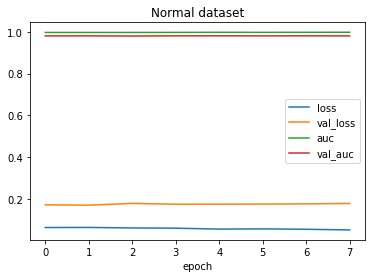

--------------------------------------------------
TN: 7656	 FP: 301 
FN: 184	 TP: 3859
The sensitivity/recall is: 95.45%
The specificity is: 96.22%
The precision is: 92.76%
--------------------------------------------------


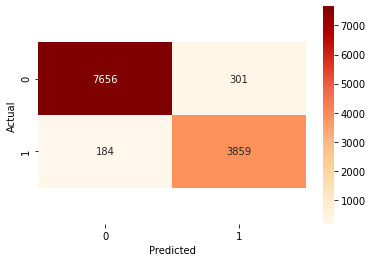

F1 score: 0.941, AUC score: 0.958


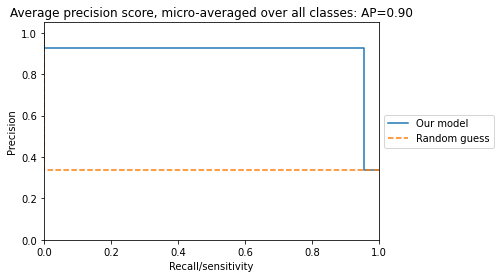

In [131]:
model(True,100000,True)
batch_size = 128
epochs = 8
stuttHistory = stuttModel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,validation_split=0.2)
stuttScore = stuttModel.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
plt.plot(stuttHistory.history['loss'])
plt.plot(stuttHistory.history['val_loss'])
plt.plot(stuttHistory.history['auc_11'])
plt.plot(stuttHistory.history['val_auc_11'])
plt.xlabel('epoch')
plt.title("Oversampled dataset")
plt.legend(['loss', 'val_loss','auc','val_auc'])
plt.show()
pred = stuttModel.predict(x_test,batch_size=128, verbose=1)
y_scores = pred
for line in range(pred.shape[0]):
    for item in range(pred.shape[1]):
        if pred[line,item] > 0.5:
            pred[line,item] = 1
        else:
            pred[line,item] = 0
s_totals_mat = confusion_matrix(y_test.astype(int).ravel(), pred.astype(int).ravel())
plot_conf_mat(s_totals_mat)
calc_precision_recall(y_test, y_scores, average_param = "micro", y_pred_ = pred )

## Here we'll not be using oversampling

| train_data shape: (80000,)
| 80000 train samples
| 20000 test samples
Train on 6400 samples, validate on 1600 samples
Epoch 1/8
6400/6400 [==============================] - 12s 2ms/sample - loss: 0.0779 - auc_11: 0.9952 - val_loss: 0.1680 - val_auc_11: 0.9808
Epoch 2/8
6400/6400 [==============================] - 12s 2ms/sample - loss: 0.0776 - auc_11: 0.9952 - val_loss: 0.1658 - val_auc_11: 0.9811
Epoch 3/8
6400/6400 [==============================] - 12s 2ms/sample - loss: 0.0709 - auc_11: 0.9960 - val_loss: 0.1711 - val_auc_11: 0.9808
Epoch 4/8
6400/6400 [==============================] - 12s 2ms/sample - loss: 0.0729 - auc_11: 0.9959 - val_loss: 0.1723 - val_auc_11: 0.9803
Epoch 5/8
6400/6400 [==============================] - 12s 2ms/sample - loss: 0.0693 - auc_11: 0.9962 - val_loss: 0.1785 - val_auc_11: 0.9809
Epoch 6/8
6400/6400 [==============================] - 12s 2ms/sample - loss: 0.0691 - auc_11: 0.9962 - val_loss: 0.1809 - val_auc_11: 0.9805
Epoch 7/8
6400/6400 [=======

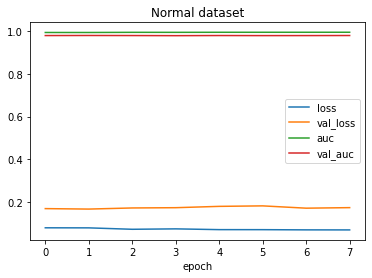

--------------------------------------------------
TN: 7625	 FP: 332 
FN: 211	 TP: 3832
The sensitivity/recall is: 94.78%
The specificity is: 95.83%
The precision is: 92.03%
--------------------------------------------------


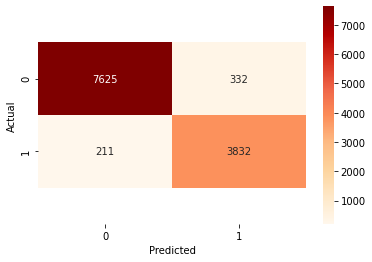

F1 score: 0.934, AUC score: 0.953


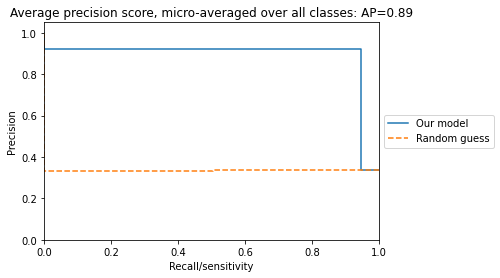

In [130]:
model(False,100000,False)
batch_size = 128
epochs = 8
stuttHistory = stuttModel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,validation_split=0.2)
stuttScore = stuttModel.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

plt.plot(stuttHistory.history['loss'])
plt.plot(stuttHistory.history['val_loss'])
plt.plot(stuttHistory.history['auc_11'])
plt.plot(stuttHistory.history['val_auc_11'])
plt.xlabel('epoch')
plt.title("Normal dataset")
plt.legend(['loss', 'val_loss','auc','val_auc'])
plt.show()
pred = stuttModel.predict(x_test,batch_size=128, verbose=1)
y_scores = pred
for line in range(pred.shape[0]):
    for item in range(pred.shape[1]):
        if pred[line,item] > 0.5:
            pred[line,item] = 1
        else:
            pred[line,item] = 0
s_totals_mat = confusion_matrix(y_test.astype(int).ravel(), pred.astype(int).ravel())
plot_conf_mat(s_totals_mat)
calc_precision_recall(y_test, y_scores, average_param = "micro", y_pred_ = pred )